<a href="https://colab.research.google.com/github/Abhi23run/CSE8803_DLT_Project/blob/main/evaluation_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install be-great
!pip install openpyxl

In [2]:
# from be_great import GReaT
import pandas as pd
import torch
import xlrd
from openpyxl import load_workbook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('float_format', '{:f}'.format)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Capgemini-Practicum

/content/drive/MyDrive/Capgemini-Practicum


**Loading in the Training (Original Dataset) and (Generated Dataset)**

In [6]:
##Original Datasets
df_original_visit_1=pd.read_csv('/content/drive/MyDrive/Capgemini-Practicum/Dataset/df_merged_transformed_v2.csv',index_col=False)
df_original_visit_2=pd.read_csv('/content/drive/MyDrive/Capgemini-Practicum/Dataset/df_merged_transformed_v1.csv',index_col=False)
df_original_visit_3=pd.read_csv('/content/drive/MyDrive/Capgemini-Practicum/Dataset/df_merged_transformed_v0.csv',index_col=False)

In [7]:
df_original_visit_1.shape,df_original_visit_2.shape,df_original_visit_3.shape

((4816, 15), (4275, 27), (3628, 39))

In [8]:
##Simulated Examples
df_simulated_visit_1=pd.read_csv('/content/drive/MyDrive/Capgemini-Practicum/Dataset/gpt2_model_baseline_merged_df_v2.csv',index_col=False)
df_simulated_visit_2=pd.read_csv('/content/drive/MyDrive/Capgemini-Practicum/Dataset/gpt2_model_baseline_merged_df_v1.csv',index_col=False)
df_simulated_visit_3=pd.read_csv('/content/drive/MyDrive/Capgemini-Practicum/Dataset/synthetic_merged_data_baseline.csv',index_col=False)

In [9]:
df_simulated_visit_1.shape,df_simulated_visit_2.shape,df_simulated_visit_3.shape

((2000, 15), (1000, 27), (500, 39))

In [10]:
df_simulated_visit_1.columns

Index(['patient_id', 'gender_code', 'birth_date', 'visit_1_cpt_code',
       'visit_1_primary_diagnosis_code', 'visit_1_visit_start_date',
       'visit_1_visit_end_date', 'visit_1_billed_amount',
       'visit_1_paid_amount', 'visit_1_ndc', 'visit_1_drug_name',
       'visit_1_fill_date', 'visit_1_paid_date', 'visit_1_billed_amount_pharm',
       'visit_1_paid_amount_pharm'],
      dtype='object')

In [11]:
df_simulated_visit_1['gender_code'].value_counts()

M    1057
F     943
Name: gender_code, dtype: int64

In [12]:
!pip install sdv --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.4 MB/s eta 0:00:00


In [13]:
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import get_column_plot

In [14]:
import pandas as pd
import re

def transform_dataframe(df):
    # Function to rename columns using regex
    def rename_columns(df_visit, visit_number):
        new_columns = {}
        for col in df_visit.columns:
            match = re.match(f'visit_{visit_number}_(.*)', col)
            if match:
                new_columns[col] = match.group(1)
        return df_visit.rename(columns=new_columns)

    # Extracting visit numbers
    visit_numbers = set(re.match(r'visit_(\d+)_', col).group(1) for col in df.columns if re.match(r'visit_(\d+)_', col))
    sorted_visit_numbers = sorted(visit_numbers)

    # Creating separate dataframes for each visit
    dfs = []
    for i in sorted_visit_numbers:
        cols_to_keep = ['patient_id', 'gender_code', 'birth_date']
        cols_for_visit = [col for col in df.columns if f'visit_{i}_' in col]
        df_visit = df[cols_to_keep + cols_for_visit].copy()
        df_visit = rename_columns(df_visit, i)
        dfs.append(df_visit)

    # Concatenating all visits into one DataFrame
    return pd.concat(dfs, ignore_index=True)

# Assuming you have a list of DataFrames: dfs_list
# transformed_dfs = [transform_dataframe(df) for df in dfs_list]

In [15]:
dataframes = {
    'df1': df_original_visit_1,
    'df2': df_original_visit_2,
    'df3': df_original_visit_3
}

transformed_dfs = []  # List to hold transformed DataFrames

for name, df in dataframes.items():
    print(f"Processing DataFrame: {name}")
    transformed_df = transform_dataframe(df)  # Assuming transform_dataframe is your function
    transformed_dfs.append(transformed_df)

# Concatenate all transformed DataFrames into one
final_df_original = pd.concat(transformed_dfs, ignore_index=True)


Processing DataFrame: df1
Processing DataFrame: df2
Processing DataFrame: df3


In [16]:
final_df_original.shape

(24250, 15)

In [17]:
dataframes = {
    'df1': df_simulated_visit_1,
    'df2': df_simulated_visit_2,
    'df3': df_simulated_visit_3
}

transformed_dfs = []  # List to hold transformed DataFrames

for name, df in dataframes.items():
    print(f"Processing DataFrame: {name}")
    transformed_df = transform_dataframe(df)  # Assuming transform_dataframe is your function
    transformed_dfs.append(transformed_df)

# Concatenate all transformed DataFrames into one
final_df_synthetic = pd.concat(transformed_dfs, ignore_index=True)

Processing DataFrame: df1
Processing DataFrame: df2
Processing DataFrame: df3


In [18]:
final_df_synthetic.shape

(5500, 15)

In [19]:
%ls

 be_great/   ModelDataCheckpoints/   Proposal_Research.docx
 Dataset/    Notebooks/             'Relevant Papers'/


**Defining Custom Checks**

In [28]:
def out_of_training_sample(real_data,generated_data,col):
  out_of_train_sample_codes=set(generated_data[col])-set(real_data[col])
  total_unique_codes_generated=set(generated_data[col])
  total_unique_codes_original=set(real_data[col])
  print(f"% of Out of Training Sample codes generated for {col} column is  {(len(out_of_train_sample_codes)/len(real_data[col]))*100:.2f} %")
  # return out_of_train_sample_codes
  return

In [29]:
out_of_training_sample(final_df_original,final_df_synthetic,'primary_diagnosis_code')
out_of_training_sample(final_df_original,final_df_synthetic,'cpt_code')
out_of_training_sample(final_df_original,final_df_synthetic,'drug_name')

% of Out of Training Sample codes generated for primary_diagnosis_code column is  3.32 %
% of Out of Training Sample codes generated for cpt_code column is  1.05 %
% of Out of Training Sample codes generated for drug_name column is  1.44 %


In [34]:
final_df_synthetic

,patient_id,gender_code,birth_date,cpt_code,primary_diagnosis_code,visit_start_date,visit_end_date,billed_amount,paid_amount,ndc,drug_name,fill_date,paid_date,billed_amount_pharm,paid_amount_pharm
0,p_2535,M,1992-05-24,99213,J029,2018-06-26,2018-06-26,0.000000,0.000000,5941750303.000000,CLINDAMYCYCL,2018-06-26,2018-06-26,-26.420000,0.000000
1,p_4383,M,2010-06-27,99213,R04,2018-01-20,2018-01-20,99.000000,0.000000,51868026002.000000,AMPHETAMINE,2018-01-20,2018-01-20,0.000000,0.000000
2,p_3665,F,1968-11-22,99214,D939,2018-04-29,2018-04-29,49.000000,0.000000,54005010.000000,CEFDINIR,2018-04-29,2018-04-29,0.000000,0.000000
3,p_2664,M,1993-08-06,99383,J111,2018-05-29,2018-05-29,120.000000,0.000000,16714020520.000000,IBUPROFEN,2018-06-27,2018-06-27,0.000000,0.000000
4,p_1717,M,1989-09-08,99214,Z0000,2018-01-25,2018-01-25,170.000000,0.000000,704320615.000000,PREDNISONE,2018-01-25,2018-01-25,37.540000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,p_3264,M,1987-10-12,99213,L700,2018-11-18,2018-11-18,145.000000,0.000000,93439178.000000,IBUPROFEN,2018-11-18,2018-11-18,-542.600000,0.000000
5496,p_2864,F,1981-12-31,99213,J209,2018-08-03,2018-08-03,0.000000,0.000000,477810301.000000,VALACYCLOVIR,2018-10-11,2018-10-11,16.620000,8.680000
5497,p_2479,F,1980-09-16,99215,Z0000,2018-10-22,2018-10-22,304.000000,88.910000,70310905.000000,Multi-Ingredient,2018-11-26,2018-11-22,27.000000,44.770000
5498,p_2853,M,1966-08-11,99213,J020,2018-06-06,2018-06-06,150.000000,0.000000,52798010160.000000,IBUPROFEN,2018-06-06,2018-06-06,0.000000,0.000000


In [36]:
final_df_synthetic['birth_date']=pd.to_datetime(final_df_synthetic['birth_date'],errors='coerce')
final_df_synthetic['visit_start_date']=pd.to_datetime(final_df_synthetic['visit_start_date'],errors='coerce')
final_df_synthetic['visit_end_date']=pd.to_datetime(final_df_synthetic['visit_end_date'],errors='coerce')
final_df_synthetic['fill_date']=pd.to_datetime(final_df_synthetic['fill_date'],errors='coerce')
final_df_synthetic['paid_date']=pd.to_datetime(final_df_synthetic['paid_date'],errors='coerce')

In [53]:
def feasible_dates(dataset,column):
  dataset[col]=pd.to_datetime(dataset[col],errors='coerce')
  print(f"{(1-(dataset[col].isna().sum()/(len(dataset[col]))))*100:.2f} % of values for column {col} are within feasible bounds.")

In [54]:
column_list=['birth_date','visit_start_date','visit_end_date','fill_date','paid_date']
for col in column_list:
  feasible_dates(final_df_synthetic,column=col)

99.18 % of values for column birth_date are within feasible bounds.
99.15 % of values for column visit_start_date are within feasible bounds.
99.13 % of values for column visit_end_date are within feasible bounds.
98.98 % of values for column fill_date are within feasible bounds.
98.93 % of values for column paid_date are within feasible bounds.


In [56]:
(final_df_synthetic['visit_end_date']-final_df_synthetic['visit_start_date']).dt.days.value_counts()

0.000000       5444
1.000000          2
-1.000000         2
-249.000000       1
54.000000         1
40.000000         1
3.000000          1
dtype: int64

In [67]:
df_intermediate=final_df_synthetic[(final_df_synthetic['paid_date'].notna()) & (final_df_synthetic['fill_date'].notna())]
print(f"Infeasible value {round((((df_intermediate['paid_date']-df_intermediate['fill_date']).dt.days.astype(int)<0).sum()/len(df_intermediate['paid_date']))*100,2)} %")

Infeasible value 2.52 %


**Only 3 out of 5500 generated entries have visit_end_date before visit_start_date**

In [88]:
top_50_real = set(final_df_original.groupby('cpt_code')['paid_amount'].mean().sort_values(ascending=False).head(50).index.values)
top_50_syn = set(final_df_synthetic.groupby('cpt_code')['paid_amount'].mean().sort_values(ascending=False).head(50).index.values)

In [89]:
len(top_50_real.intersection(top_50_syn))

0

In [ ]:
def top_alignment(real_data,synthetic_data,base_column,agg_column, threshold=None):
  top_real = set(real_data.groupby(base_column)[agg_column].mean().sort_values(ascending=False).head(threshold).index.values)
  top_synthetic=set(synthetic_data.groupby(base_column)[agg_column].mean().sort_values(ascending=False).head(threshold).index.values)

In [ ]:
final_df_original.to_csv('Dataset/final_df_original.csv',index=False)

In [ ]:
final_df_synthetic.to_csv('Dataset/final_df_synthetic.csv',index=False)

In [ ]:
for column in final_df_original.columns[final_df_original.dtypes=='object'].values:
  final_df_original[column]=final_df_original[column].astype("category")
  final_df_synthetic[column]=final_df_synthetic[column].astype("category")

In [ ]:
final_df_original.dtypes

patient_id                category
gender_code               category
birth_date                category
cpt_code                  category
primary_diagnosis_code    category
visit_start_date          category
visit_end_date            category
billed_amount              float64
paid_amount                float64
ndc                        float64
drug_name                 category
fill_date                 category
paid_date                 category
billed_amount_pharm        float64
paid_amount_pharm          float64
dtype: object

In [20]:
def out_of_training_sample(real_data,generated_data,col):
  out_of_train_sample_codes=set(generated_data[col])-set(real_data[col])
  total_unique_codes_generated=set(generated_data[col])
  total_unique_codes_original=set(real_data[col])
  print(f"% of Out of Training Sample codes generated for {col} column is  {(len(out_of_train_sample_codes)/len(total_unique_codes_original))*100:.2f} %")
  # return out_of_train_sample_codes
  return

In [ ]:
final_df_synthetic.columns

Index(['patient_id', 'gender_code', 'birth_date', 'cpt_code',
       'primary_diagnosis_code', 'visit_start_date', 'visit_end_date',
       'billed_amount', 'paid_amount', 'ndc', 'drug_name', 'fill_date',
       'paid_date', 'billed_amount_pharm', 'paid_amount_pharm'],
      dtype='object')

In [ ]:
out_of_training_sample(final_df_original,final_df_synthetic,'primary_diagnosis_code')
out_of_training_sample(final_df_original,final_df_synthetic,'cpt_code')
out_of_training_sample(final_df_original,final_df_synthetic,'drug_name')

% of Out of Training Sample codes generated for primary_diagnosis_code column is  28.47 %
% of Out of Training Sample codes generated for cpt_code column is  21.60 %
% of Out of Training Sample codes generated for drug_name column is  38.54 %


In [ ]:
final_df_synthetic['patient_id']

,patient_id,gender_code,birth_date,cpt_code,primary_diagnosis_code,visit_start_date,visit_end_date,billed_amount,paid_amount,ndc,drug_name,fill_date,paid_date,billed_amount_pharm,paid_amount_pharm
0,p_2535,M,1992-05-24,99213,J029,2018-06-26,2018-06-26,0.000000,0.000000,5941750303.000000,CLINDAMYCYCL,2018-06-26,2018-06-26,-26.420000,0.000000
1,p_4383,M,2010-06-27,99213,R04,2018-01-20,2018-01-20,99.000000,0.000000,51868026002.000000,AMPHETAMINE,2018-01-20,2018-01-20,0.000000,0.000000
2,p_3665,F,1968-11-22,99214,D939,2018-04-29,2018-04-29,49.000000,0.000000,54005010.000000,CEFDINIR,2018-04-29,2018-04-29,0.000000,0.000000
3,p_2664,M,1993-08-06,99383,J111,2018-05-29,2018-05-29,120.000000,0.000000,16714020520.000000,IBUPROFEN,2018-06-27,2018-06-27,0.000000,0.000000
4,p_1717,M,1989-09-08,99214,Z0000,2018-01-25,2018-01-25,170.000000,0.000000,704320615.000000,PREDNISONE,2018-01-25,2018-01-25,37.540000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,p_3264,M,1987-10-12,99213,L700,2018-11-18,2018-11-18,145.000000,0.000000,93439178.000000,IBUPROFEN,2018-11-18,2018-11-18,-542.600000,0.000000
5496,p_2864,F,1981-12-31,99213,J209,2018-08-03,2018-08-03,0.000000,0.000000,477810301.000000,VALACYCLOVIR,2018-10-11,2018-10-11,16.620000,8.680000
5497,p_2479,F,1980-09-16,99215,Z0000,2018-10-22,2018-10-22,304.000000,88.910000,70310905.000000,Multi-Ingredient,2018-11-26,2018-11-22,27.000000,44.770000
5498,p_2853,M,1966-08-11,99213,J020,2018-06-06,2018-06-06,150.000000,0.000000,52798010160.000000,IBUPROFEN,2018-06-06,2018-06-06,0.000000,0.000000


**Adversarial Validation**

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [ ]:
final_df_originall

In [ ]:
# select only the numerical features
# X_train=df_original_visit_1.loc[:,~df_original_visit_1.columns.str.contains('ndc')].select_dtypes(include=np.number).copy(deep=True)
X_train=final_df_original.loc[:,~final_df_original.columns.str.contains('ndc|patient')].select_dtypes(include=np.number).copy(deep=True)
X_test=final_df_synthetic.loc[:,~final_df_synthetic.columns.str.contains('ndc|patient')].select_dtypes(include=np.number).copy(deep=True)
# X_test=df_simulated_visit_1.loc[:,~df_simulated_visit_1.columns.str.contains('ndc|patient')]

In [ ]:
X_train=final_df_original.loc[:,~final_df_original.columns.str.contains('ndc|patient')]
X_test=final_df_synthetic.loc[:,~final_df_synthetic.columns.str.contains('ndc|patient')]

In [ ]:
# add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

In [ ]:
# make one big dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

In [ ]:
# shuffle
all_data_shuffled = all_data.sample(frac=1)

In [ ]:
X_train.shape,X_test.shape,all_data.shape,all_data_shuffled.shape

((24250, 14), (5500, 14), (29750, 14), (29750, 14))

In [ ]:
for column in all_data_shuffled.columns[all_data_shuffled.dtypes=='object'].values:
  all_data_shuffled[column]=all_data_shuffled[column].astype("category")

In [ ]:
all_data_shuffled.dtypes

gender_code               category
birth_date                category
cpt_code                  category
primary_diagnosis_code    category
visit_start_date          category
visit_end_date            category
billed_amount              float64
paid_amount                float64
drug_name                 category
fill_date                 category
paid_date                 category
billed_amount_pharm        float64
paid_amount_pharm          float64
AV_label                     int64
dtype: object

In [ ]:
# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y, enable_categorical=True)

In [ ]:
# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

In [ ]:
# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params,
                       nfold=5, metrics="auc",
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

199   0.980081
Name: test-auc-mean, dtype: float64


In [ ]:
X.dtypes

gender_code               category
birth_date                category
cpt_code                  category
primary_diagnosis_code    category
visit_start_date          category
visit_end_date            category
billed_amount              float64
paid_amount                float64
drug_name                 category
fill_date                 category
paid_date                 category
billed_amount_pharm        float64
paid_amount_pharm          float64
dtype: object

**Feature Importance**

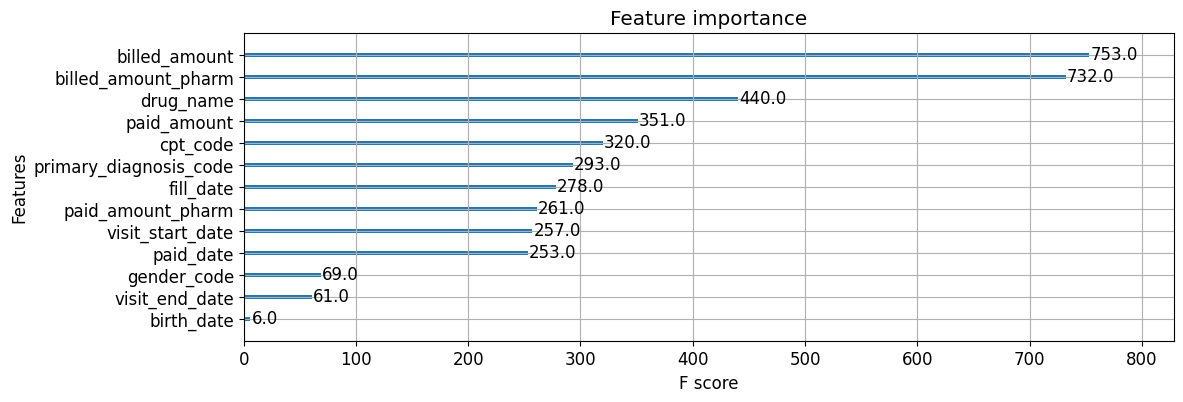

In [ ]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False,enable_categorical=True)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4))
plot_importance(classifier, ax=ax)
plt.show();

In [ ]:
# X.drop(columns=['billed_amount','billed_amount_pharm','drug_name'],inplace=True)
X.drop(columns=['drug_name'],inplace=True)
XGBdata = xgb.DMatrix(data=X,label=y,enable_categorical=True)
cross_val_results = cv(dtrain=XGBdata, params=params,
                       nfold=5, metrics="auc",
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

print((cross_val_results["test-auc-mean"]).tail(1))

199   0.924465
Name: test-auc-mean, dtype: float64


In [ ]:
final_df_original.shape, final_df_synthetic.shape

((24250, 15), (5500, 15))

In [ ]:
graph_cols = final_df_original.columns[~final_df_original.columns.str.contains('patient|ndc')]
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=final_df_original.loc[:,graph_cols])

In [ ]:
python_dict = metadata.to_dict()
python_dict

{'columns': {'gender_code': {'sdtype': 'categorical'},
  'birth_date': {'sdtype': 'datetime'},
  'cpt_code': {'sdtype': 'categorical'},
  'primary_diagnosis_code': {'sdtype': 'categorical'},
  'visit_start_date': {'sdtype': 'datetime'},
  'visit_end_date': {'sdtype': 'datetime'},
  'billed_amount': {'sdtype': 'numerical'},
  'paid_amount': {'sdtype': 'numerical'},
  'drug_name': {'sdtype': 'categorical'},
  'fill_date': {'sdtype': 'datetime'},
  'paid_date': {'sdtype': 'datetime'},
  'billed_amount_pharm': {'sdtype': 'numerical'},
  'paid_amount_pharm': {'sdtype': 'numerical'}},
 'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1'}

In [ ]:
final_df_synthetic['birth_date']=pd.to_datetime(final_df_synthetic['birth_date'],errors='coerce')
final_df_synthetic['visit_start_date']=pd.to_datetime(final_df_synthetic['visit_start_date'],errors='coerce')
final_df_synthetic['visit_end_date']=pd.to_datetime(final_df_synthetic['visit_end_date'],errors='coerce')
final_df_synthetic['fill_date']=pd.to_datetime(final_df_synthetic['fill_date'],errors='coerce')
final_df_synthetic['paid_date']=pd.to_datetime(final_df_synthetic['paid_date'],errors='coerce')

In [ ]:
for col in graph_cols:
    fig = get_column_plot(
        real_data=final_df_original,
        synthetic_data=final_df_synthetic,
        column_name=col,
        metadata=metadata
    )

    fig.show()

In [ ]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_report = run_diagnostic(
    real_data=final_df_original,
    synthetic_data=final_df_synthetic,
    metadata=metadata)

Generating report ...
(3/3) Evaluating Synthesis: : 100%|██████████| 1/1 [02:15<00:00, 135.24s/it]

Diagnostic Results:

SUCCESS:
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data
✓ Over 90% of the synthetic rows are not copies of the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data

DANGER:
x The synthetic data is missing more than 50% of the categories present in the real data


In [ ]:
graph_cols

Index(['gender_code', 'birth_date', 'cpt_code', 'primary_diagnosis_code',
       'visit_start_date', 'visit_end_date', 'billed_amount', 'paid_amount',
       'drug_name', 'fill_date', 'paid_date', 'billed_amount_pharm',
       'paid_amount_pharm'],
      dtype='object')

In [ ]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=final_df_original.loc[:,graph_cols],
    synthetic_data=final_df_synthetic.loc[:,graph_cols],
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 78/78 [02:07<00:00,  1.63s/it]

Overall Quality Score: 72.26%

Properties:
- Column Shapes: 80.0%
- Column Pair Trends: 64.51%


In [ ]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,gender_code,TVComplement,0.990482
1,birth_date,KSComplement,0.933233
2,cpt_code,TVComplement,0.630027
3,primary_diagnosis_code,TVComplement,0.532984
4,visit_start_date,KSComplement,0.958929
5,visit_end_date,KSComplement,0.958795
6,billed_amount,KSComplement,0.821201
7,paid_amount,KSComplement,0.519026
8,drug_name,TVComplement,0.631405
9,fill_date,KSComplement,0.906684


In [ ]:
final_df_original['primary_diagnosis_code']

0           J111
1          Z0000
2           B349
3            I10
4        S43402A
          ...   
24245      G4733
24246       M545
24247      F4323
24248       C162
24249        R05
Name: primary_diagnosis_code, Length: 24250, dtype: object